In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.6 MB/s eta 0:00:00


In [2]:
from transformers import BertTokenizer
#import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer
import torch.nn.functional as F


In [3]:
import pickle
from google.colab import drive
import pandas as pd

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
with open('/content/drive/MyDrive/pred_2021_04.pickle','rb') as f:
  kl=pickle.load(f)

In [6]:
batch=pd.DataFrame(kl)

In [7]:
batch.head()

,id,tags,headline,timestamp,headline_len
0,214442,"[{'coin': {'name': 'Elrond', 'ticker': 'EGLD',...",rt beniaminmincu simplest way stake period,2021-04-01 00:02:02+00:00,49
1,214441,"[{'coin': None, 'id': 311, 'name': 'Partnershi...",qtum partner vaccin forward help support cov...,2021-04-01 00:02:05+00:00,140
2,214443,"[{'coin': None, 'id': 371, 'name': 'CoinList',...",chequered_flag ralli token sale amp distribut...,2021-04-01 00:03:04+00:00,347
3,454235,"[{'coin': {'name': 'Ethereum', 'ticker': 'ETH'...",thank amaz project help usher era ethere...,2021-04-01 00:07:41.414000+00:00,140
4,454234,"[{'coin': {'name': 'Loopring', 'ticker': 'LRC'...",orderbook market maker sweet reward whet...,2021-04-01 00:07:41.470000+00:00,140


FinBERT

In [13]:
#logits = model_output[0]
#softmax_output = F.softmax(logits, dim=1).cpu().detach().numpy()


In [15]:
#sentiment_score = softmax_output[:, 2] - softmax_output[:, 0]

In [16]:
#sentiment_score

array([-1.2399164e-06,  4.7840740e-07, -2.5574986e-06, -1.4786424e-06,
       -7.6219567e-07,  1.1371162e-06, -6.1492210e-07, -2.4444757e-06,
       -1.2399164e-06,  5.0378594e-07, -2.6021098e-07, -2.8160912e-07,
       -3.0534684e-06, -5.1931875e-07, -1.8084806e-06, -1.6802833e-06,
       -3.2572734e-07, -2.9987136e-06, -2.8160912e-07, -2.6021098e-07,
       -2.9987136e-06, -8.2115457e-07, -1.6802833e-06, -2.3088396e-06,
       -2.5955487e-06,  3.5340508e-07, -2.2204185e-06,  4.0365890e-06,
       -3.3145352e-06, -2.4059023e-06, -9.4937195e-07, -3.3145352e-06,
       -2.4059023e-06,  7.4329319e-07, -1.4456791e-06,  1.4522134e-06,
       -7.8695211e-07, -6.0360480e-07,  1.0538961e-06,  2.4960173e-08,
        4.8898846e-07, -1.7435746e-06,  6.4365668e-07, -2.8161899e-06,
       -7.0327269e-07, -1.6121899e-06,  8.0852851e-07, -1.8067744e-06,
       -6.4139567e-07, -2.8161899e-06, -1.9816732e-06,  6.4365668e-07,
       -1.6121899e-06, -1.0927181e-06, -1.3599738e-06,  8.0852851e-07,
      

In [9]:
import numpy as np

In [10]:
batch.headline=batch.headline + " [SEP] "

In [16]:
from typing import Tuple, List
import torch

In [17]:
class FinBertCased:
    def __init__(self, max_len: int, batch_size: int, model_path: str):
        self.max_len = max_len
        self.model_path = model_path
        self.batch_size= batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_path).eval().to('cuda')
        self.label_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
        self.inverse_label_dict = {v: k for k, v in self.label_dict.items()}

    def full_preprocess(self, text: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Preprocessing pipeline from string to ids and attention mask. """
        encoded = self.tokenizer(text, 
                                 add_special_tokens=True,
                                 max_length=self.max_len,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 return_tensors='pt',
                                 truncation=True)
        input_ids = torch.cat([encoded['input_ids']], dim=0).to('cuda')
        attention_mask = torch.cat([encoded['attention_mask']], dim=0).to('cuda')
        return input_ids, attention_mask

    def predict_raw(self, text: List[str]) -> torch.Tensor:
        """ Predict raw logits """
        input_ids, attention_mask = self.full_preprocess(text)
        model_output = self.model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = model_output[0]
        return logits

    def predict_score(self, text: List[str]) -> np.float32:
        """ Predict a single sentiment score (positive_sentiment - negative_sentiment) """
        logits = self.predict_raw(text)
        softmax_output = F.softmax(logits, dim=1).cpu().detach().numpy()
        pos_idx = self.inverse_label_dict['positive']
        neg_idx = self.inverse_label_dict['negative']
        return softmax_output[:, pos_idx] - softmax_output[:, neg_idx]

    def predict_signals(self, text: pd.Series) -> List[float]:
        """
        Get ranking of average sentiment scores for every ticker in the data.
        :param text: Pandas Series of articles grouped by week and ticker
        :return: Scaled sentiment scores in range [0...1]
        """
        sent_scores = []
        for row in tqdm(text):
            sents = row.split(" [SEP] ")[:-1]
            sent_scores_ticker = []
            for batch in self._chunks(sents, self.batch_size):
                batch_sents = self.predict_score(batch)
                sent_scores_ticker.append(batch_sents)
            mean_score = np.array(np.concatenate(sent_scores_ticker)).ravel().mean()
            sent_scores.append(mean_score)
        #signals = self._scale_sentiment(sent_scores)
        return sent_scores
    
    @staticmethod
    def _chunks(lst, n):
        """ Yield successive n-sized chunks from list. """
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    @staticmethod
    def _scale_sentiment(sentiments: List[float]):
        """ Scale sentiment scores from [-1...1] to [0...1] """
        mm = MinMaxScaler()
        sent_proc = np.array(sentiments).reshape(-1, 1)
        return mm.fit_transform(sent_proc)

In [18]:
MAX_LEN = 256
BATCH_SIZE = 8
MODEL_PATH = "ipuneetrathore/bert-base-cased-finetuned-finBERT"

In [14]:
import os
import ast
import torch
import pickle
import requests
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from typing import Tuple, List
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta, FR

In [19]:
fbc = FinBertCased(max_len=MAX_LEN, batch_size=BATCH_SIZE, model_path=MODEL_PATH)

In [20]:
batch.loc[:,'signal'] = fbc.predict_signals(batch.headline)

100%|██████████| 39351/39351 [09:11<00:00, 71.31it/s]


In [21]:
batch.signal

0       -1.239907e-06
1        4.784033e-07
2       -2.557492e-06
3       -1.478648e-06
4       -7.621925e-07
             ...     
39346   -2.005934e-06
39347   -1.731979e-06
39348    3.991418e-07
39349   -3.853579e-07
39350    1.080055e-06
Name: signal, Length: 39351, dtype: float32

In [22]:
batch

,id,tags,headline,timestamp,headline_len,signal
0,214442,"[{'coin': {'name': 'Elrond', 'ticker': 'EGLD',...",rt beniaminmincu simplest way stake period ...,2021-04-01 00:02:02+00:00,49,-1.239907e-06
1,214441,"[{'coin': None, 'id': 311, 'name': 'Partnershi...",qtum partner vaccin forward help support cov...,2021-04-01 00:02:05+00:00,140,4.784033e-07
2,214443,"[{'coin': None, 'id': 371, 'name': 'CoinList',...",chequered_flag ralli token sale amp distribut...,2021-04-01 00:03:04+00:00,347,-2.557492e-06
3,454235,"[{'coin': {'name': 'Ethereum', 'ticker': 'ETH'...",thank amaz project help usher era ethere...,2021-04-01 00:07:41.414000+00:00,140,-1.478648e-06
4,454234,"[{'coin': {'name': 'Loopring', 'ticker': 'LRC'...",orderbook market maker sweet reward whet...,2021-04-01 00:07:41.470000+00:00,140,-7.621925e-07
...,...,...,...,...,...,...
39346,246254,"[{'coin': None, 'id': 187, 'name': 'Announceme...",rt coinight glowing_star zilliqa announc new...,2021-04-30 23:32:02+00:00,153,-2.005934e-06
39347,246255,"[{'coin': {'name': 'Ethereum', 'ticker': 'ETH'...",ethereum move toward eth super experiment tes...,2021-04-30 23:33:09+00:00,63,-1.731979e-06
39348,246256,"[{'coin': None, 'id': 187, 'name': 'Announceme...",rt wpeaster th banklesshq week book saw a...,2021-04-30 23:38:03+00:00,140,3.991418e-07
39349,246257,"[{'coin': {'name': 'Cardano', 'ticker': 'ADA',...",great atmpool thewhiterabbit first plut...,2021-04-30 23:42:05+00:00,304,-3.853579e-07


In [23]:
with open('/content/drive/MyDrive/batch_1_0_1.pickle', 'wb') as f:
    pickle.dump(batch, f, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
import matplotlib.pyplot as plt

In [35]:
batch_h

0       -1.239907e-06
1        4.784033e-07
2       -2.557492e-06
3       -1.478648e-06
4       -7.621925e-07
             ...     
39346   -2.005934e-06
39347   -1.731979e-06
39348    3.991418e-07
39349   -3.853579e-07
39350    1.080055e-06
Name: signal, Length: 39351, dtype: float32

In [38]:
batch=batch.sort_values('timestamp')

<Axes: xlabel='timestamp'>

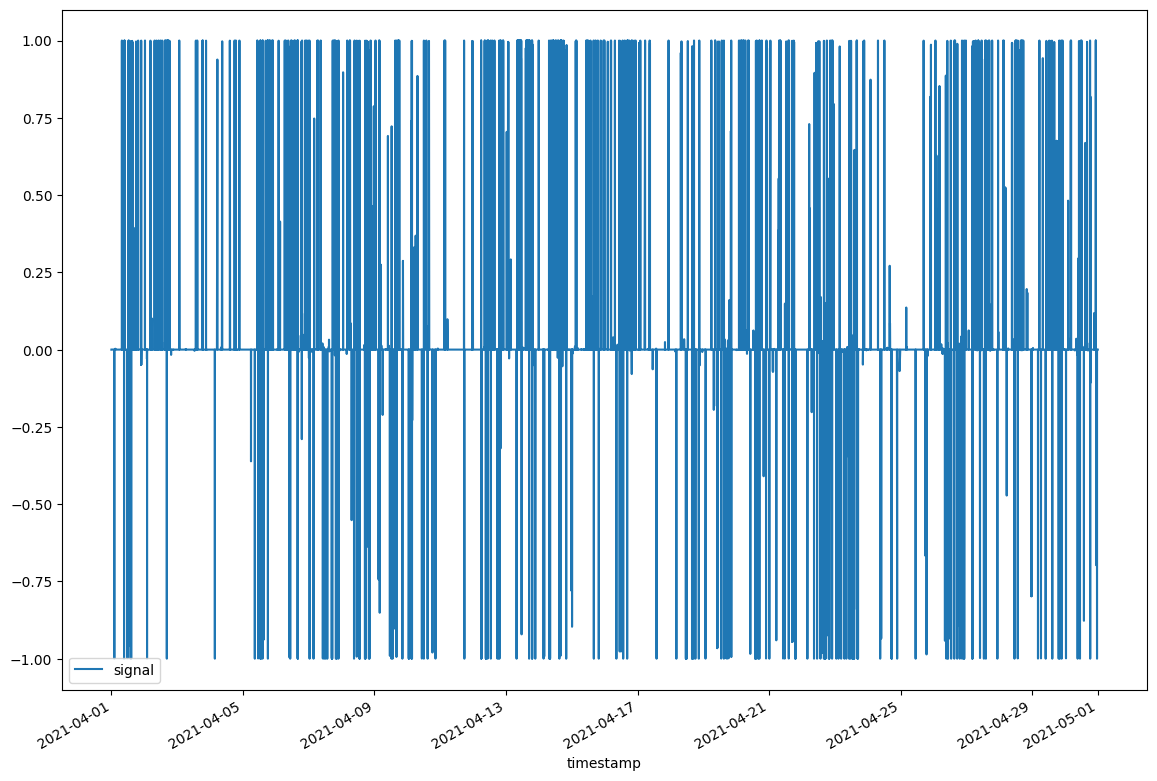

In [39]:
batch.plot(x='timestamp', y='signal', figsize=(14,10))

In [42]:
batch['timestamp']=batch['timestamp'].dt.date
batch.head()


,id,tags,headline,timestamp,headline_len,signal
0,214442,"[{'coin': {'name': 'Elrond', 'ticker': 'EGLD',...",rt beniaminmincu simplest way stake period ...,2021-04-01,49,-1.239907e-06
1,214441,"[{'coin': None, 'id': 311, 'name': 'Partnershi...",qtum partner vaccin forward help support cov...,2021-04-01,140,4.784033e-07
2,214443,"[{'coin': None, 'id': 371, 'name': 'CoinList',...",chequered_flag ralli token sale amp distribut...,2021-04-01,347,-2.557492e-06
3,454235,"[{'coin': {'name': 'Ethereum', 'ticker': 'ETH'...",thank amaz project help usher era ethere...,2021-04-01,140,-1.478648e-06
4,454234,"[{'coin': {'name': 'Loopring', 'ticker': 'LRC'...",orderbook market maker sweet reward whet...,2021-04-01,140,-7.621925e-07


In [72]:
batch['tags'][2][0].get('coin').get('ticker')

AttributeError: ignored

In [83]:
btc_batch=[]
for i in tqdm(range(len(batch))):
  if type(batch.tags[i])!= float:
    for j in range(len(batch.tags[i])):
      try:
        tik=batch.tags[i][j].get('coin').get('ticker')
        if tik=='BTC':
            btc_batch.append(batch.loc[i])
      except Exception:
        pass

100%|██████████| 39351/39351 [00:01<00:00, 22229.48it/s]


In [86]:
btcbatch=pd.DataFrame(btc_batch,columns=['id','tags', 'headline','timestamp','headline_len','signal'])
len(btcbatch)

3853

In [87]:
df_mean=btcbatch[['timestamp', 'signal']]
df_mean=df_mean.groupby('timestamp').mean()
df_mean.head()

,signal
timestamp,
2021-04-01,-0.006501
2021-04-02,0.028715
2021-04-03,0.039922
2021-04-04,0.000002
2021-04-05,0.015140


<Axes: xlabel='timestamp'>

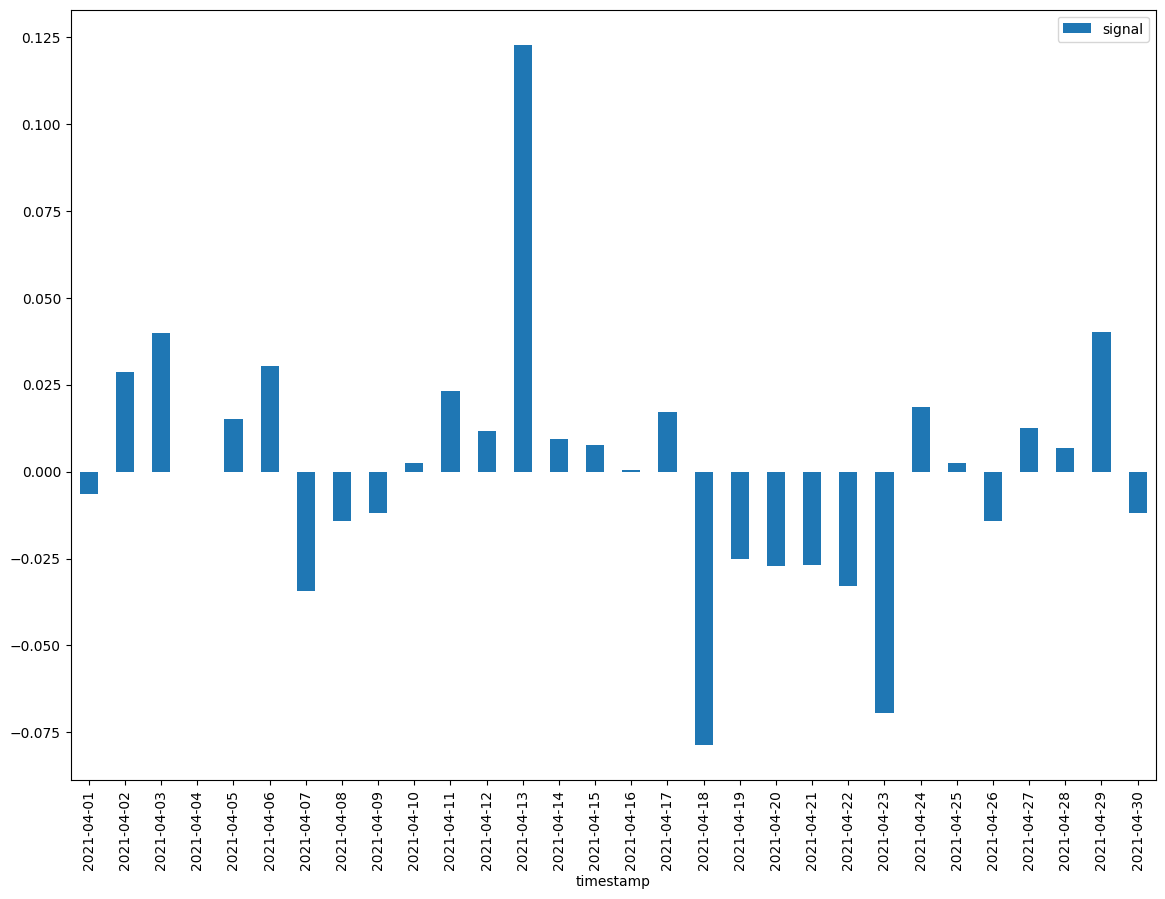

In [88]:
df_mean.plot.bar(figsize=(14,10))

In [91]:
with open('/content/drive/MyDrive/btcbatch0421.pickle', 'wb') as f:
    pickle.dump(btcbatch, f, protocol=pickle.HIGHEST_PROTOCOL)

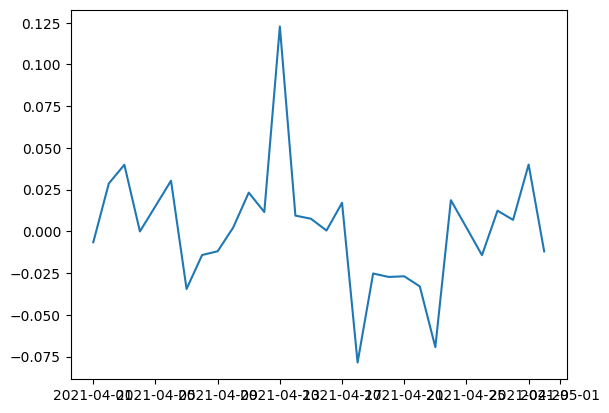

In [90]:
plt.plot(df_mean['signal'])

<Axes: ylabel='Frequency'>

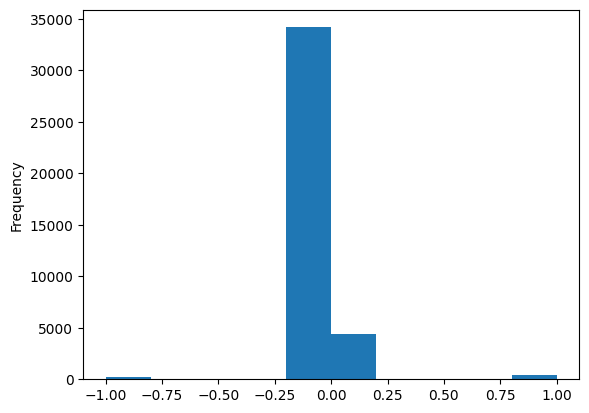

In [51]:
batch.signal.plot(kind="hist")

Bert

In [19]:
with open('/content/drive/MyDrive/batch.pickle','rb') as f:
   kl=pickle.load(f)

EOFError: ignored

In [20]:
with open('/content/drive/MyDrive/data_en_6.pickle','rb') as f:
   kl=pickle.load(f)

In [21]:
bert_batch=kl
bert_batch.head()

,tags,topics,timestamp,prepared_data,len_text
1,"[{'coin': {'name': 'Elrond', 'ticker': 'EGLD',...",RT @beniaminmincu: Simplest way to stake. Period.,2021-04-01 00:02:02+00:00,"[rt, beniaminmincu, simplest, way, stake, period]",6
2,"[{'coin': None, 'id': 311, 'name': 'Partnershi...",Qtum partners with Vaccine Forward to help sup...,2021-04-01 00:02:05+00:00,"[qtum, partner, vaccin, forward, help, support...",11
3,"[{'coin': None, 'id': 371, 'name': 'CoinList',...",🏁 THE RALLY TOKEN SALE &amp; DISTRIBUTION ON C...,2021-04-01 00:03:04+00:00,"[ralli, token, sale, amp, distribut, coinlist,...",24
5,"[{'coin': {'name': 'Ethereum', 'ticker': 'ETH'...",Thank you to the amazing projects helping ushe...,2021-04-01 00:07:41.414000+00:00,"[thank, amaz, project, help, usher, era, ether...",11
6,"[{'coin': {'name': 'Loopring', 'ticker': 'LRC'...","For the orderbook market makers, we have those...",2021-04-01 00:07:41.470000+00:00,"[orderbook, market, maker, sweet, reward, whet...",10


In [9]:
MAX_LEN = 256
BATCH_SIZE = 8
MODEL_PATH = "bert-base-uncased"

In [32]:
bc = FinBertCased(max_len=MAX_LEN, batch_size=BATCH_SIZE, model_path=MODEL_PATH)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [33]:
batch.loc[:,'signal_bert'] = bc.predict_signals(bert_batch.headline)

  0%|          | 0/39351 [00:00<?, ?it/s]


(1, 2)


ValueError: ignored

In [79]:
model= "bert-base-uncased"

In [98]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

class SentimentClassifier:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.model.eval()

    def predict(self, text):
        inputs = self.tokenizer.encode_plus(text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
        outputs = self.model(**inputs)
        #probabilities = torch.softmax(outputs.logits, dim=-1)
        sentiment = torch.softmax(outputs.logits, dim=1)  # можно заменить на возвращение вероятностей

        return sentiment[0][1]-sentiment[0][0]

# Загрузите вашу обученную модель и токенизатор


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

classifier = SentimentClassifier(model, tokenizer)

# Ваш список тестовых текстов
test_texts = batch.headline

for i in range(len(test_texts)):
    batch.col[i] = classifier.predict(test_texts[i])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [104]:
batch.col[0]

'partnership announc  httpstcofjxvcdhsuj  partnership  bring epicent stablecoin eusd onto kadenaswap  combin  strength  eusd decentr   secur  kadena smart contract languag pact read  httpstcobfeipnkcq httpstcolyaknnjnv   [SEP] '